<a href="https://colab.research.google.com/github/Tower5954/TensorFlow/blob/main/05_Transfer_learning_in_TensorFlow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, in this notebook we will go through a new kind of transfer learning: fine-tuning

In [52]:
# Check if we are using a GPU
!nvidia-smi

Wed Dec 22 03:42:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    58W / 149W |    207MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

It is a good idea, to put functions that you will use a lot in a script, that you can download and import into your notebooks (or elsewhere).

We have done this for some of the functions previously used here:
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [53]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-12-22 03:42:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-12-22 03:42:02 (64.2 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [54]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

## The data

This time we will see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recognising images of food)
link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [55]:
# Get 10% of training data of 10 classes of food 101

In [56]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2021-12-22 03:42:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   215MB/s    in 0.7s    

2021-12-22 03:42:03 (215 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [57]:
unzip_data("10_food_classes_10_percent.zip")

In [58]:
# check how many images and subdirectories in the dataset

In [59]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [60]:
# Create training and test 

In [61]:
train_dir = "10_food_classes_10_percent/train" 
test_dir = "10_food_classes_10_percent/test"

In [62]:
import tensorflow as tf
IMG_SIZE = (254,254)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)


test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [63]:
train_data_10_percent

<BatchDataset shapes: ((None, 254, 254, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [64]:
# Check the class names of the dataset

In [65]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [66]:
# See an example of a batch of data

for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[254.        254.        254.       ]
   [253.        255.        254.       ]
   [253.        255.        254.       ]
   ...
   [254.        254.        254.       ]
   [254.        254.        254.       ]
   [254.        254.        254.       ]]

  [[254.        254.        254.       ]
   [253.        255.        254.       ]
   [253.        255.        254.       ]
   ...
   [254.        254.        254.       ]
   [254.        254.        254.       ]
   [254.        254.        254.       ]]

  [[254.        254.        254.       ]
   [253.        255.        254.       ]
   [253.        255.        254.       ]
   ...
   [254.        254.        254.       ]
   [254.        254.        254.       ]
   [254.        254.        254.       ]]

  ...

  [[253.        253.        253.       ]
   [249.90552   249.90552   249.90552  ]
   [240.30315   240.30315   240.30315  ]
   ...
   [254.        254.        254.       ]
   [254.        254.        254.       ]
   [2

## Model 0: Building a transfer learning feature extraction model using the keras functional API.

---



The sequential API is straightforward, it runs the layers in sequential order.

However, the functional API  gives more flexiability with models.
link: https://www.tensorflow.org/guide/keras/functional?hl=en

**1.** Create a base model with tf.keras.applications.

In [67]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)



---



**2**. Freeze the base model (so the underlying pre-trained patterns aren't updated during training).

In [68]:
base_model.trainable = False



---






**3**. Create inputs in to the model.

In [69]:
inputs = tf.keras.layers.Input(shape=(254,254,3), name='input_layer')





---






**4**. If using ResNet50V2 you will need to normalise inputs (you don't have to for EffecientNet(s)).


In [70]:
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)



---



**5**. Pass the inputs to the base_model.

In [71]:
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape} ")

Shape after passing inputs through base model: (None, 7, 7, 1280) 




---





**6**. Average pool the outputs of the base model (aggregate all the most importantinformation, reduce number of computations). 

In [72]:
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
print(f"Shape after GlobalAveragePooling2d: {x.shape}")

Shape after GlobalAveragePooling2d: (None, 1280)




---

**7**. Create the output activation layer.

In [73]:
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)



---

**8**. Combine the inputs with the outputs into a model.

In [74]:
model_0 = tf.keras.Model(inputs,outputs)



---

**9**. Compile the model

In [75]:
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



---



**10**. Fit the model and save the history

In [76]:
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name="10_percent_feature_extraction")]
                                 )

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20211222-034209
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 25s 399ms/step - loss: 1.9411 - accuracy: 0.3680 - val_loss: 1.3630 - val_accuracy: 0.7089
Epoch 2/5
24/24 [==============================] - 9s 379ms/step - loss: 1.1535 - accuracy: 0.7560 - val_loss: 0.9284 - val_accuracy: 0.8010
Epoch 3/5
24/24 [==============================] - 8s 305ms/step - loss: 0.8442 - accuracy: 0.8107 - val_loss: 0.7645 - val_accuracy: 0.8191
Epoch 4/5
24/24 [==============================] - 9s 379ms/step - loss: 0.6843 - accuracy: 0.8600 - val_loss: 0.6443 - val_accuracy: 0.8372
Epoch 5/5
24/24 [==============================] - 8s 308ms/step - loss: 0.5842 - accuracy: 0.8613 - val_loss: 0.5902 - val_accuracy: 0.8388


In [77]:
# Evaluate on the full test data

model_0.evaluate(test_data)

79/79 [==============================] - 13s 157ms/step - loss: 0.6033 - accuracy: 0.8432


[0.6032732725143433, 0.8432000279426575]

In [78]:
# Check the layers in the base model

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_3
1 rescaling_2
2 normalization_2
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [79]:
# Summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

In [81]:
# Summary of the whole model

model_0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 254, 254, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


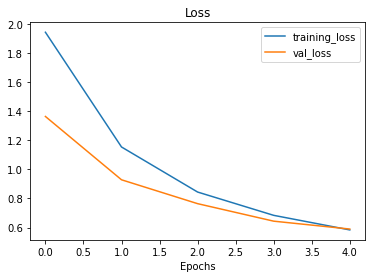

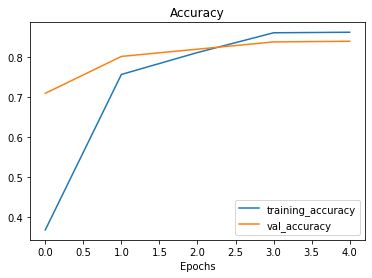

In [82]:
# Check the model'straining curves
plot_loss_curves(history_10_percent)